In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from umap import UMAP

import pancancer_evaluation.config as cfg
from csd_simulations import simulate_csd
from preprocess_and_score_models import fit_k_folds_all_models

np.random.seed(42)
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

### Simulate data from multiple "domains"

Main simulation code is in `09_simulations/csd_simulations.py`.

In [2]:
# see 09_simulations/csd_simulations.py for details on simulation parameters
# TODO: write bash script to run experiments for a variety of parameter settings
n_domains = 5
n_per_domain = 50
p = 20
k = 5
noise_scale = 1.5

corr_top, diag = 1, None
# corr_top, diag = 0.5, 5
# corr_top, diag = 0.1, 10

correlated_noise = True

# location to save plots to
output_plots = True
sim_results_dir = cfg.repo_root / '09_simulations' / 'simulation_results'
output_plots_dir = cfg.repo_root / '09_simulations' / 'simulation_plots'

In [3]:
xs, ys = simulate_csd(n_domains, n_per_domain, p, k, 
                      corr_noise=correlated_noise,
                      noise_scale=noise_scale,
                      corr_top=corr_top,
                      diag=diag)

print(xs.shape)
print(xs[:5, :5])

(250, 20)
[[ 1.28828102 -0.8085964  -0.45043737  2.14735295 -3.2518469 ]
 [ 1.01378829 -4.0306337  -2.99138792  2.93119506 -4.82641655]
 [ 1.88286051 -5.24705024 -0.13954148  2.79446203 -3.62264743]
 [ 2.49753911 -1.61833458 -4.86647454  4.11383995 -4.74531711]
 [ 0.91061687 -4.53663677 -3.79499793  2.56645773 -3.93350473]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(250, 1)
[[ 1]
 [ 1]
 [-1]]


### Plot simulated data

We'll do this using both PCA and UMAP, side by side. We can color by domain and use different shapes for each label, to get an idea of how data clusters with respect to domain and how separable we expect different labels to be across domains.

In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,10.440638,-6.210529,0,1
1,10.231043,-6.616573,0,1
2,9.990054,-7.128282,0,-1
3,9.851095,-7.610100,0,-1
4,9.575669,-7.595281,0,-1


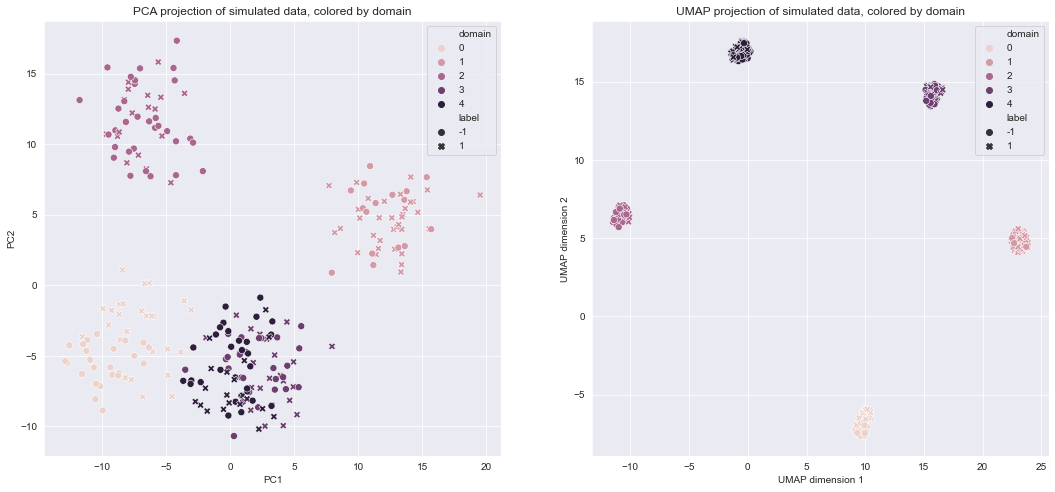

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_pca_umap.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### Random train/test splitting

Just split the data randomly here, across all of the simulated domains, and fit some models to the split data. This gives us an idea of what baseline performance we should expect when we have access to training data from all domains.

In [7]:
results_df = fit_k_folds_all_models(xs, ys, domains[:, np.newaxis])
results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,model,fold,metric,value
0,ridge,0,train_auroc,0.627461
1,random_forest,0,train_auroc,0.897894
2,mlp,0,train_auroc,0.997711
3,linear_csd,0,train_auroc,0.808951
4,ridge,1,train_auroc,0.774621


In [8]:
sim_results_dir.mkdir(exist_ok=True)
results_df.to_csv(
    sim_results_dir / 'n{}_p{}_k{}_corr{}_scale{}_random.tsv'.format(
        n_domains, p, k, corr_top, diag), sep='\t')

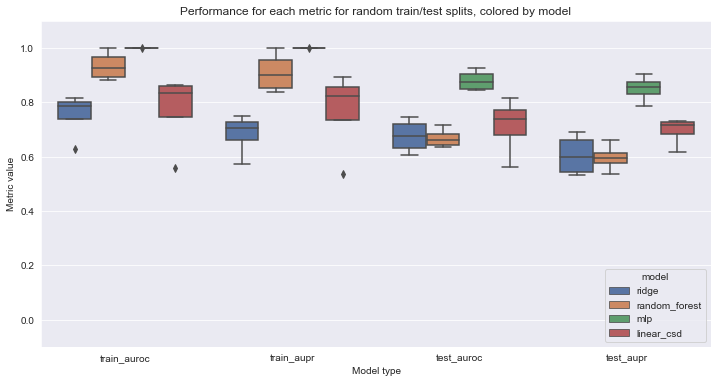

In [9]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df.sort_values(by='metric', ascending=False),
            x='metric', y='value', hue='model')
plt.title('Performance for each metric for random train/test splits, colored by model')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_random_perf.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### Domain holdout train/test splitting

Here, we want to hold out a single domain and train on the other domains. This simulates the case when we have access to some domains during training, and we want to measure generalization to domains that we can't train on for whatever reason.

In [10]:
# hold out domain that was generated last; use all other domains for training
holdout_domain = np.unique(domains)[-1]
X_train = xs[domains != holdout_domain, :]
X_holdout = xs[domains == holdout_domain, :]
y_train = ys[domains != holdout_domain, :]
y_holdout = ys[domains == holdout_domain, :]
ds_train = domains[domains != holdout_domain, np.newaxis]
ds_holdout = domains[domains == holdout_domain, np.newaxis]

results_df = fit_k_folds_all_models(
    X_holdout, y_holdout, ds_holdout, train_data=(X_train, y_train, ds_train)
)
results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,model,fold,metric,value
0,ridge,0,train_auroc,0.8050
1,random_forest,0,train_auroc,1.0000
2,mlp,0,train_auroc,0.9980
3,linear_csd,0,train_auroc,0.8554
4,ridge,1,train_auroc,0.8050


In [11]:
results_df.to_csv(
    sim_results_dir / 'n{}_p{}_k{}_corr{}_scale{}_domain.tsv'.format(
        n_domains, p, k, corr_top, diag), sep='\t')

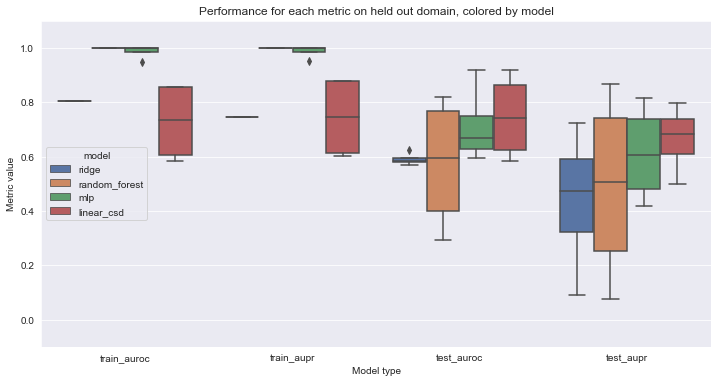

In [12]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df.sort_values(by='metric', ascending=False),
            x='metric', y='value', hue='model')
plt.title('Performance for each metric on held out domain, colored by model')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_domain_perf.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### CORAL

Apply the [CORAL transformation](https://arxiv.org/abs/1612.01939) for unsupervised domain adaptation to the holdout domain. This should help a bit with performance, but not as much as adding the CSD layer since the data is generated using the CSD generative model.

In [13]:
# apply CORAL to map X_train onto X_holdout
from transfertools.models import CORAL

print(X_train.shape, X_holdout.shape)
X_train_coral, X_holdout_coral = CORAL().fit_transfer(X_train, X_holdout)

(200, 20) (50, 20)


In [14]:
xs_coral = np.concatenate((X_train_coral, X_holdout_coral))
print(xs_coral.shape)

(250, 20)


In [15]:
# visualize X_train and X_holdout before and after CORAL transformation
pca = PCA(n_components=2)
X_proj_pca_coral = pca.fit_transform(xs_coral)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap_coral = reducer.fit_transform(xs_coral)

coral_train = np.concatenate((
    [True] * X_train_coral.shape[0],
    [False] * X_holdout_coral.shape[0]
))

X_pca_coral_df = pd.DataFrame(X_proj_pca_coral,
                              columns=['PC{}'.format(j) for j in range(X_proj_pca_coral.shape[1])])
X_pca_coral_df['coral_train'] = coral_train
X_pca_coral_df['label'] = ys.flatten()

X_umap_coral_df = pd.DataFrame(X_proj_umap_coral,
                               columns=['UMAP{}'.format(j) for j in range(X_proj_umap_coral.shape[1])])
X_umap_coral_df['coral_train'] = coral_train
X_umap_coral_df['label'] = ys.flatten()

X_umap_coral_df.head()

,UMAP0,UMAP1,coral_train,label
0,4.924421,7.592520,True,1
1,5.115104,7.494002,True,1
2,5.155956,7.765605,True,-1
3,4.042254,7.331691,True,-1
4,4.239429,7.145919,True,-1


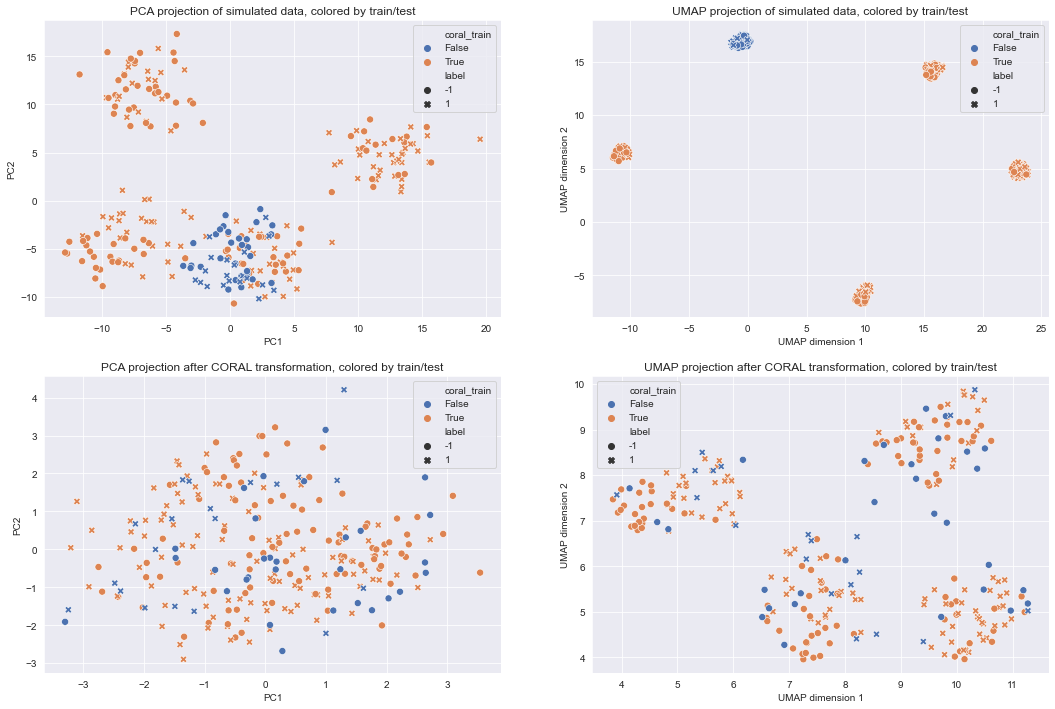

In [16]:
sns.set({'figure.figsize': (18, 12)})
fig, axarr = plt.subplots(2, 2)

X_pca_df['coral_train'] = (domains != holdout_domain)
X_umap_df['coral_train'] = (domains != holdout_domain)
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='coral_train', style='label', s=50, ax=axarr[0, 0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='coral_train', style='label', s=50, ax=axarr[0, 1])
    
axarr[0, 0].set_title('PCA projection of simulated data, colored by train/test')
axarr[0, 0].set_xlabel('PC1')
axarr[0, 0].set_ylabel('PC2')
axarr[0, 0].legend()
axarr[0, 1].set_title('UMAP projection of simulated data, colored by train/test')
axarr[0, 1].set_xlabel('UMAP dimension 1')
axarr[0, 1].set_ylabel('UMAP dimension 2')
axarr[0, 1].legend()

sns.scatterplot(data=X_pca_coral_df, x='PC0', y='PC1', hue='coral_train', style='label', s=50, ax=axarr[1, 0])
sns.scatterplot(data=X_umap_coral_df, x='UMAP0', y='UMAP1', hue='coral_train', style='label', s=50, ax=axarr[1, 1])
    
axarr[1, 0].set_title('PCA projection after CORAL transformation, colored by train/test')
axarr[1, 0].set_xlabel('PC1')
axarr[1, 0].set_ylabel('PC2')
axarr[1, 0].legend()
axarr[1, 1].set_title('UMAP projection after CORAL transformation, colored by train/test')
axarr[1, 1].set_xlabel('UMAP dimension 1')
axarr[1, 1].set_ylabel('UMAP dimension 2')
axarr[1, 1].legend()

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_coral_pca_umap.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

In [17]:
# train model using CORAL-transformed training data, aligned to test domain, as input
coral_results_df = fit_k_folds_all_models(
    X_holdout_coral, y_holdout, ds_holdout, train_data=(X_train_coral, y_train, ds_train)
)
coral_results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,model,fold,metric,value
0,ridge,0,train_auroc,0.8100
1,random_forest,0,train_auroc,1.0000
2,mlp,0,train_auroc,0.9988
3,linear_csd,0,train_auroc,0.8761
4,ridge,1,train_auroc,0.8100


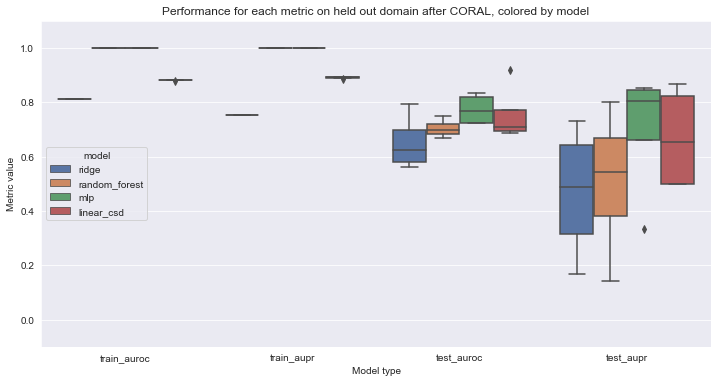

In [18]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=coral_results_df.sort_values(by='metric', ascending=False),
            x='metric', y='value', hue='model')
plt.title('Performance for each metric on held out domain after CORAL, colored by model')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_coral_perf.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

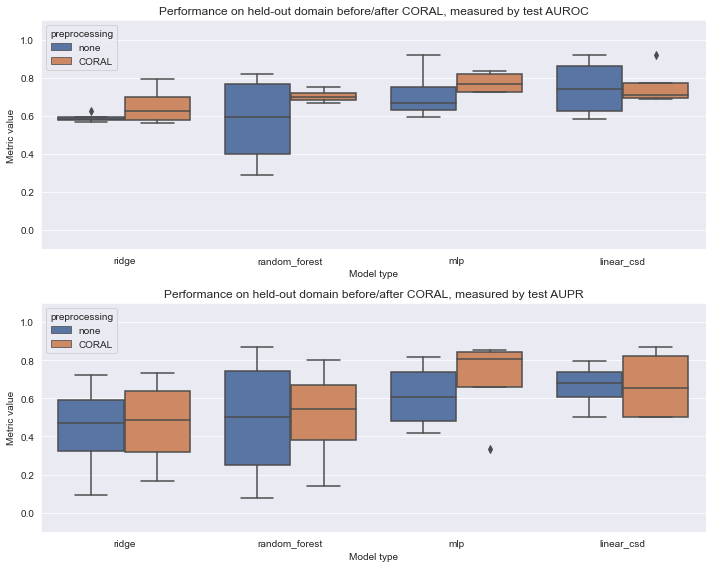

In [19]:
results_df['preprocessing'] = 'none'
coral_results_df['preprocessing'] = 'CORAL'

coral_results_df = pd.concat((results_df, coral_results_df))

sns.set({'figure.figsize': (10, 8)})
fig, axarr = plt.subplots(2, 1)

sns.boxplot(data=coral_results_df[coral_results_df.metric == 'test_auroc'],
            x='model', y='value', hue='preprocessing', ax=axarr[0])
axarr[0].set_title('Performance on held-out domain before/after CORAL, measured by test AUROC')
axarr[0].set_xlabel('Model type')
axarr[0].set_ylabel('Metric value')
axarr[0].set_ylim(-0.1, 1.1)

sns.boxplot(data=coral_results_df[coral_results_df.metric == 'test_aupr'],
            x='model', y='value', hue='preprocessing', ax=axarr[1])
axarr[1].set_title('Performance on held-out domain before/after CORAL, measured by test AUPR')
axarr[1].set_xlabel('Model type')
axarr[1].set_ylabel('Metric value')
axarr[1].set_ylim(-0.1, 1.1)

plt.tight_layout()

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_coral_comparison.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### Random split with dummy covariate for domain

Does providing the domain information (in the form of a dummy/one-hot variable) help performance?

In [20]:
x_covariates = pd.get_dummies(domains)
x_covariates.head()

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [21]:
xs_cov = np.concatenate((xs, x_covariates.values), axis=1)
print(xs_cov[:5, :])

[[  1.28828102  -0.8085964   -0.45043737   2.14735295  -3.2518469
   -2.33662062  -1.79340842  -2.65456608  -3.66530604  -0.07567767
   -5.1731465    1.12756253  -7.09816041  -0.14432827   1.28031325
   -1.09854394   1.58167008   7.5500807   -0.4905088    7.17652777
    1.           0.           0.           0.           0.        ]
 [  1.01378829  -4.0306337   -2.99138792   2.93119506  -4.82641655
   -6.50993018   1.26523367   0.68355705  -4.17124373   0.47166492
   -0.79714691  -1.00747554 -10.60324439   2.04158216  -2.51909774
   -1.81287209   4.02086706   8.83358617  -0.45013941   5.72987557
    1.           0.           0.           0.           0.        ]
 [  1.88286051  -5.24705024  -0.13954148   2.79446203  -3.62264743
   -4.64069259   2.05099432   4.11180827  -0.53987445  -0.52720569
   -1.71402552  -2.72679958  -4.98147679   0.21763798  -1.92843689
   -3.59865119   0.0816403   10.26138985  -1.62914916   1.83744984
    1.           0.           0.           0.           0.   

In [22]:
cov_results_df = fit_k_folds_all_models(xs_cov, ys, domains[:, np.newaxis])
cov_results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,model,fold,metric,value
0,ridge,0,train_auroc,0.627461
1,random_forest,0,train_auroc,0.940419
2,mlp,0,train_auroc,0.899038
3,linear_csd,0,train_auroc,0.804716
4,ridge,1,train_auroc,0.833965


In [23]:
cov_results_df.to_csv(
    sim_results_dir / 'n{}_p{}_k{}_corr{}_scale{}_random_dummy.tsv'.format(
        n_domains, p, k, corr_top, diag), sep='\t')

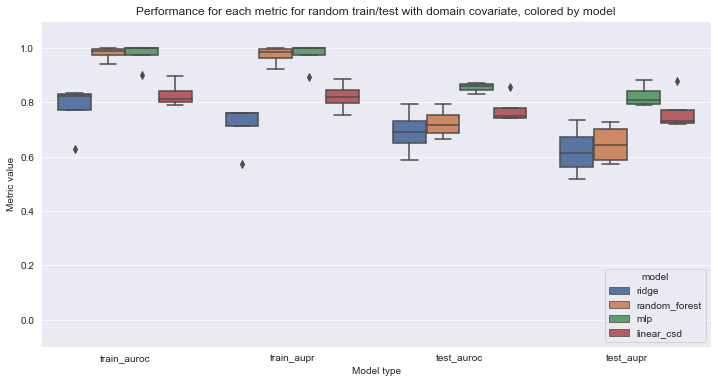

In [24]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=cov_results_df.sort_values(by='metric', ascending=False),
            x='metric', y='value', hue='model')
plt.title('Performance for each metric for random train/test with domain covariate, colored by model')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_dummy_perf.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

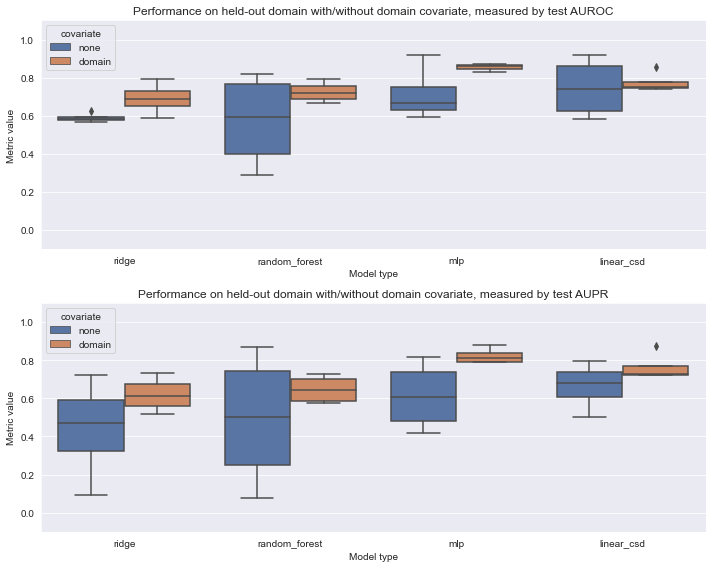

In [25]:
results_df['covariate'] = 'none'
cov_results_df['covariate'] = 'domain'

cov_results_df = pd.concat((results_df, cov_results_df))

sns.set({'figure.figsize': (10, 8)})
fig, axarr = plt.subplots(2, 1)

sns.boxplot(data=cov_results_df[cov_results_df.metric == 'test_auroc'],
            x='model', y='value', hue='covariate', ax=axarr[0])
axarr[0].set_title('Performance on held-out domain with/without domain covariate, measured by test AUROC')
axarr[0].set_xlabel('Model type')
axarr[0].set_ylabel('Metric value')
axarr[0].set_ylim(-0.1, 1.1)

sns.boxplot(data=cov_results_df[cov_results_df.metric == 'test_aupr'],
            x='model', y='value', hue='covariate', ax=axarr[1])
axarr[1].set_title('Performance on held-out domain with/without domain covariate, measured by test AUPR')
axarr[1].set_xlabel('Model type')
axarr[1].set_ylabel('Metric value')
axarr[1].set_ylim(-0.1, 1.1)

plt.tight_layout()

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_dummy_comparison.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')